# Für Elise Synthesis, Playback, and Waveform Visualization

This notebook demonstrates:
- Extracting a melody from a MusicXML file (e.g., a transcription of Beethoven's "Für Elise")
- Generating frequencies for notes using an A4 = 440 Hz reference
- Synthesizing sound via sine wave generation with a short fade-in/fade-out envelope
- Optionally generating a richer electronic piano-like tone using harmonics and an ADSR envelope
- Visualizing the generated waveforms using matplotlib

**Requirements:**
- numpy
- simpleaudio
- music21
- matplotlib

You can install these packages with:
```bash
pip install numpy simpleaudio music21 matplotlib
```

In [54]:
import numpy as np
import simpleaudio as sa
import time
from music21 import converter, note, chord
import matplotlib.pyplot as plt
import random

In [8]:
def generate_notes(start_octave=0, end_octave=8):
    """
    Generate a dictionary mapping note names (e.g., C4, D#4) to their frequencies.
    Calculation uses the equal-tempered scale with A4=440 Hz as the reference.
    """
    note_names = ["C", "C#", "D", "D#", "E", "F",
                  "F#", "G", "G#", "A", "A#", "B"]
    notes = {}
    A4 = 440.0
    A4_index = note_names.index("A")
    A4_octave = 4

    for octave in range(start_octave, end_octave + 1):
        for i, n in enumerate(note_names):
            note_name = f"{n}{octave}"
            semitone_diff = (octave - A4_octave) * 12 + (i - A4_index)
            frequency = A4 * (2 ** (semitone_diff / 12))
            notes[note_name] = frequency
    return notes

# Generate the dictionary for later use.
notes_dict = generate_notes(0, 8)
print("Generated notes dictionary")

Generated notes dictionary


In [117]:
def extract_melody(musicxml_path):
    """
    Extract a monophonic melody from a MusicXML file.
    
    Each note is represented as a tuple: (note_name, duration)
    Duration is taken from note.duration.quarterLength.
    Notes (or chords) with a zero duration (likely grace notes) are given a minimal value.
    """
    score = converter.parse(musicxml_path)
    melody = []
    for element in score.flat.notes:
        if isinstance(element, note.Rest):
            melody.append(("rest", element.duration.quarterLength))
        elif isinstance(element, note.Note):
            duration = get_duration(element.duration.quarterLength)
            melody.append((str(element.pitch), duration))
        elif isinstance(element, chord.Chord):
            duration = get_duration(element.duration.quarterLength)
            melody.append((str(element.root()), duration))
    return melody

def get_duration(duration):
   return duration * 0.25

#Example usage (uncomment if you have a MusicXML file named 'FurElise.xml'):
melody = extract_melody('FurElise.xml')
print(melody[:10])

[('E5', 0.125), ('D#5', 0.125), ('E5', 0.125), ('D#5', 0.125), ('E5', 0.125), ('B4', 0.125), ('D5', 0.125), ('C5', 0.125), ('A4', 0.375), ('A2', 0.0)]


In [172]:
def generate_sine_wave(frequency, duration, sample_rate=44100, amplitude=32767, fade_duration=0.005):
    """
    Generate a sine wave with a short fade-in and fade-out to reduce clicks.
    """
    samples = int(sample_rate * duration)
    t = np.linspace(0, duration, samples, False)
    wave = amplitude * np.sin(2 * np.pi * frequency * t)
    
    fade_samples = int(sample_rate * fade_duration)
    if fade_samples > 0 and fade_samples * 2 < samples:
        fade_in = np.linspace(0.0, 1.0, fade_samples)
        fade_out = np.linspace(1.0, 0.0, fade_samples)
        envelope = np.ones(samples)
        envelope[:fade_samples] = fade_in
        envelope[-fade_samples:] = fade_out
        wave *= envelope

    return wave.astype(np.int16)

def generate_harmonic_wave(frequency, duration, harmonics=[1, 0.5, 0.25, 0.125], sample_rate=44100, amplitude=32767, fade_duration=0.005):
    """
    Generate a complex tone by adding harmonics, and apply a fade-in/fade-out envelope.
    """
    samples = int(sample_rate * duration)
    t = np.linspace(0, duration, samples, False)
    wave = np.zeros(samples)

    # Add base tone and its harmonics.
    for i, harmonic_amplitude in enumerate(harmonics, start=1):
        wave += harmonic_amplitude * np.sin(2 * np.pi * frequency * i * t)

    # Normalize the resulting waveform.
    wave *= amplitude / np.max(np.abs(wave))

    # Apply a short fade (to avoid clicks).
    fade_samples = int(sample_rate * fade_duration)
    if fade_samples > 0 and fade_samples * 2 < samples:
        envelope = np.ones(samples)
        envelope[:fade_samples] = np.linspace(0, 1, fade_samples)
        envelope[-fade_samples:] = np.linspace(1, 0, fade_samples)
        wave *= envelope

    return wave.astype(np.int16)

def generate_square_wave(frequency, duration, sample_rate=44100, amplitude=32767, fade_duration=0.005):
    """
    Generate a square wave with a short fade-in and fade-out to reduce clicks.
    
    Parameters:
        frequency (float): Frequency of the note in Hz.
        duration (float): Duration of the note in seconds.
        sample_rate (int): Number of samples per second.
        amplitude (int): The maximum amplitude (for 16-bit audio, typically 32767).
        fade_duration (float): Duration in seconds of fade-in and fade-out.
    
    Returns:
        numpy.ndarray: The generated square wave as 16-bit audio data.
    """
    samples = int(sample_rate * duration)
    t = np.linspace(0, duration, samples, False)
    # Generate square wave using the sign of a sine wave.
    wave = amplitude * np.sign(np.sin(2 * np.pi * frequency * t))
    
    fade_samples = int(sample_rate * fade_duration)
    if fade_samples > 0 and fade_samples * 2 < samples:
        fade_in = np.linspace(0.0, 1.0, fade_samples)
        fade_out = np.linspace(1.0, 0.0, fade_samples)
        envelope = np.ones(samples)
        envelope[:fade_samples] = fade_in
        envelope[-fade_samples:] = fade_out
        wave = wave * envelope

    return wave.astype(np.int16)

def generate_sawtooth_wave(frequency, duration, sample_rate=44100, amplitude=32767, fade_duration=0.005):
    """
    Generate a sawtooth wave with a short fade-in and fade-out to reduce clicks.
    
    Parameters:
        frequency (float): Frequency of the note in Hz.
        duration (float): Duration of the note in seconds.
        sample_rate (int): Number of samples per second.
        amplitude (int): The maximum amplitude (for 16-bit audio, typically 32767).
        fade_duration (float): Duration in seconds of fade-in and fade-out.
    
    Returns:
        numpy.ndarray: The generated sawtooth wave as 16-bit audio data.
    """
    samples = int(sample_rate * duration)
    t = np.linspace(0, duration, samples, False)
    # Generate sawtooth wave: ranges from -1 to 1.
    wave = amplitude * (2 * (t * frequency - np.floor(t * frequency)) - 1)
    
    fade_samples = int(sample_rate * fade_duration)
    if fade_samples > 0 and fade_samples * 2 < samples:
        fade_in = np.linspace(0.0, 1.0, fade_samples)
        fade_out = np.linspace(1.0, 0.0, fade_samples)
        envelope = np.ones(samples)
        envelope[:fade_samples] = fade_in
        envelope[-fade_samples:] = fade_out
        wave = wave * envelope

    return wave.astype(np.int16)

def generate_triangle_wave(frequency, duration, sample_rate=44100, amplitude=32767, fade_duration=0.005):
    """
    Generate a triangle wave with a short fade-in and fade-out to reduce clicks.
    
    Parameters:
        frequency (float): Frequency of the note in Hz.
        duration (float): Duration of the note in seconds.
        sample_rate (int): Number of samples per second.
        amplitude (int): The maximum amplitude for 16-bit audio (typically 32767).
        fade_duration (float): Duration in seconds of the fade-in/out.
    
    Returns:
        numpy.ndarray: The generated triangle wave as 16-bit audio data.
    """
    import numpy as np
    # Total number of samples in the wave.
    samples = int(sample_rate * duration)
    # Create a time array. Use endpoint=False for a periodic waveform.
    t = np.linspace(0, duration, samples, endpoint=False)
    
    # Generate a triangle wave using the standard formula.
    # The inner expression produces a sawtooth-like ramp, which is then "folded" by taking the absolute value.
    triangle = 2 * np.abs(2 * (t * frequency - np.floor(t * frequency + 0.5))) - 1
    
    # Scale the triangle wave to the desired amplitude.
    wave = amplitude * triangle

    # Apply fade-in and fade-out envelope to reduce clicks.
    fade_samples = int(sample_rate * fade_duration)
    if fade_samples > 0 and fade_samples * 2 < samples:
        fade_in = np.linspace(0.0, 1.0, fade_samples, endpoint=False)
        fade_out = np.linspace(1.0, 0.0, fade_samples)
        envelope = np.ones(samples)
        envelope[:fade_samples] = fade_in
        envelope[-fade_samples:] = fade_out
        wave = wave * envelope

    return wave.astype(np.int16)


def apply_adsr_envelope(wave, sample_rate, attack=0.01, decay=0.1, sustain_level=0.7, release=0.1):
    """
    Apply an ADSR envelope (Attack, Decay, Sustain, Release) to a waveform,
    and convert the result into a 16-bit integer array.
    
    Parameters:
        wave (numpy.ndarray): Input waveform (typically a sine or harmonic wave).
        sample_rate (int): The number of samples per second.
        attack (float): Attack time in seconds.
        decay (float): Decay time in seconds.
        sustain_level (float): Sustain level (0 to 1).
        release (float): Release time in seconds.
        
    Returns:
        numpy.ndarray: The waveform after applying the ADSR envelope, cast as int16.
    """
    length = len(wave)
    envelope = np.zeros(length)

    # Compute the number of samples for each segment
    attack_samples = int(sample_rate * attack)
    decay_samples = int(sample_rate * decay)
    release_samples = int(sample_rate * release)
    sustain_samples = length - (attack_samples + decay_samples + release_samples)

    # If sustain duration goes negative, adjust release_samples accordingly
    if sustain_samples < 0:
        sustain_samples = 0
        release_samples = length - (attack_samples + decay_samples)

    # Create the envelope segments:
    envelope[:attack_samples] = np.linspace(0, 1, attack_samples, endpoint=False)
    envelope[attack_samples:attack_samples + decay_samples] = np.linspace(1, sustain_level, decay_samples, endpoint=False)
    envelope[attack_samples + decay_samples:attack_samples + decay_samples + sustain_samples] = sustain_level
    envelope[-release_samples:] = np.linspace(sustain_level, 0, release_samples)

    # Apply the envelope to the wave
    new_wave = wave * envelope

    # Re-normalize the waveform to the 16-bit range if needed:
    max_val = np.max(np.abs(new_wave))
    if max_val > 0:
        new_wave = new_wave / max_val * 32767

    return new_wave.astype(np.int16)



In [191]:
attack=0.01
decay=0.1
sustain_level=0.7
release=0.1

harmonics = [1, 0.95, 0.85, 0.25]

def play_audio(audio, sample_rate):
    play_obj = sa.play_buffer(audio, 1, 2, sample_rate)
    play_obj.wait_done()

def play_note(note_str, duration, notes_dict, wave_type = 'sine', sample_rate = 44100):
    """
    Play a single note.
    If note_str is 'rest', it waits silently.
    Otherwise, it looks up the frequency, generates a sine wave, and plays it.
    A tempo adjustment is applied by dividing the duration by 4.
    """
    if duration == 0.0:
        return
    
    if note_str.lower() == "rest":
        time.sleep(duration)
    else:
        frequency = notes_dict.get(note_str)
        if frequency is None:
            print(f"Note {note_str} not found.")
            return
        
        if wave_type == 'sine':
            audio = generate_sine_wave(frequency, duration, sample_rate)
        elif wave_type == 'sine-adsr':
            audio = apply_adsr_envelope(generate_sine_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        elif wave_type == 'harmonic':
            audio = generate_harmonic_wave(frequency, duration, harmonics, sample_rate)
        elif wave_type == 'harmonic-adsr':
            audio = apply_adsr_envelope(generate_harmonic_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        elif wave_type == 'square':
            audio = generate_square_wave(frequency, duration, sample_rate)
        elif wave_type == 'square-adsr':
            audio = apply_adsr_envelope(generate_square_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        elif wave_type == 'sawtooth':
            audio = generate_sawtooth_wave(frequency, duration, sample_rate)
        elif wave_type == 'sawtooth-adsr':
            audio = apply_adsr_envelope(generate_sawtooth_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        elif wave_type == 'triangle':
            audio = generate_triangle_wave(frequency, duration, sample_rate)
        elif wave_type == 'triangle-adsr':
            audio = apply_adsr_envelope(generate_triangle_wave(frequency, duration), sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
        else:
            print(f"Unknown wave type: {wave_type}")
            return
        play_audio(audio, sample_rate)


def play_melody(melody, notes_dict, wave_type = 'sine'):
    """
    Iterate through the melody (list of tuples) and play each note.
    """
    new_wave_type = wave_type
    for note_str, duration in melody:
        print(f"Playing note: {note_str} for {duration} sec with {new_wave_type} wave")
        play_note(note_str, duration, notes_dict, new_wave_type)

play_melody(melody, notes_dict, 'triangle')

Playing note: E5 for 0.125 sec with triangle wave
Playing note: D#5 for 0.125 sec with triangle wave
Playing note: E5 for 0.125 sec with triangle wave
Playing note: D#5 for 0.125 sec with triangle wave
Playing note: E5 for 0.125 sec with triangle wave
Playing note: B4 for 0.125 sec with triangle wave
Playing note: D5 for 0.125 sec with triangle wave
Playing note: C5 for 0.125 sec with triangle wave
Playing note: A4 for 0.375 sec with triangle wave
Playing note: A2 for 0.0 sec with triangle wave
Playing note: C4 for 0.125 sec with triangle wave
Playing note: E4 for 0.125 sec with triangle wave
Playing note: A4 for 0.125 sec with triangle wave
Playing note: E3 for 0.0 sec with triangle wave
Playing note: B4 for 0.375 sec with triangle wave
Playing note: E4 for 0.125 sec with triangle wave
Playing note: G#4 for 0.125 sec with triangle wave
Playing note: B4 for 0.125 sec with triangle wave


KeyboardInterrupt: 

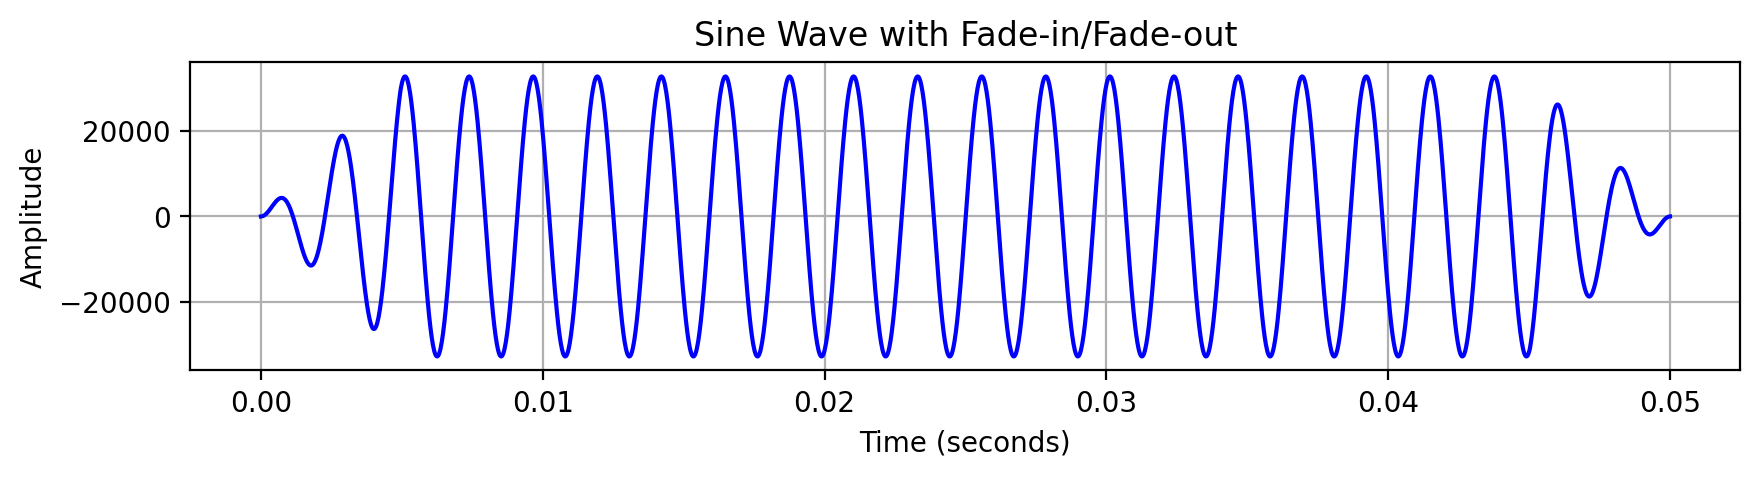

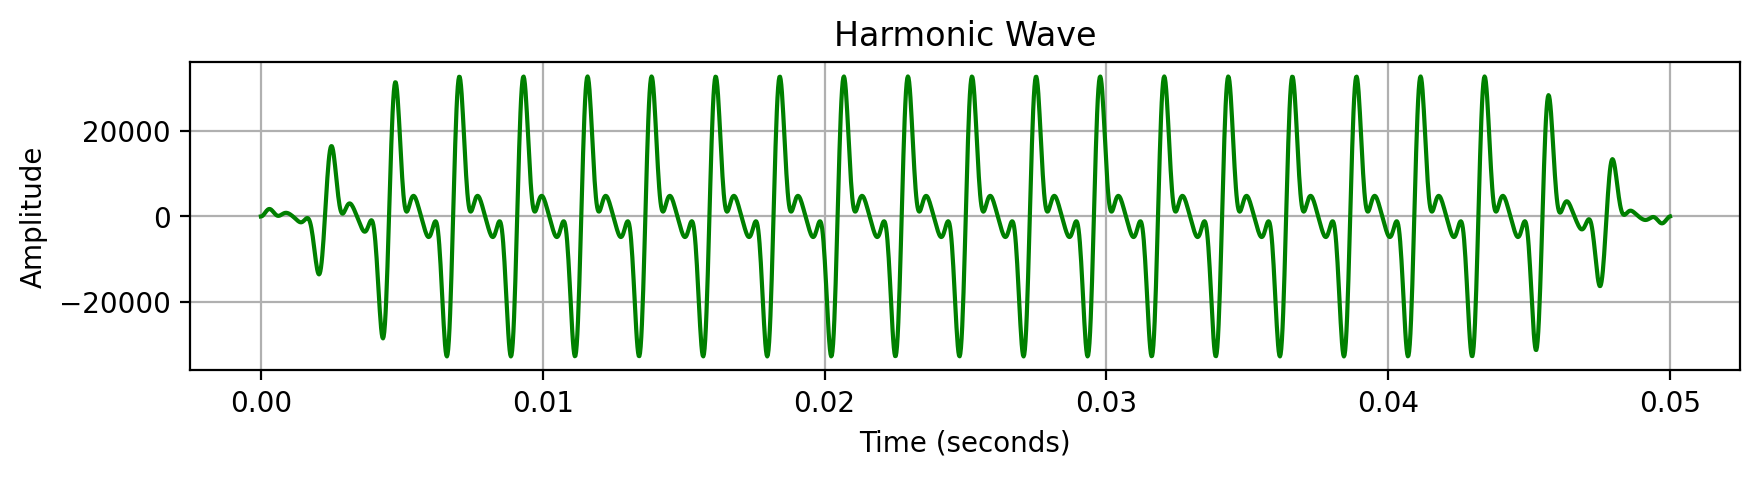

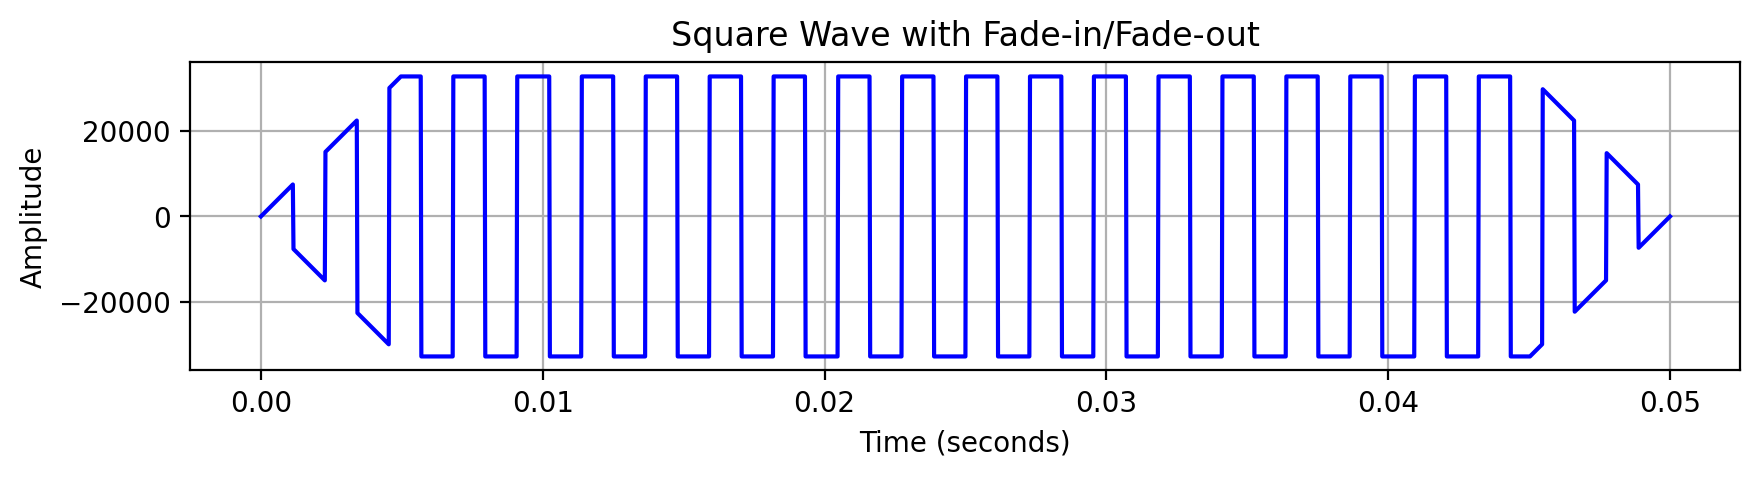

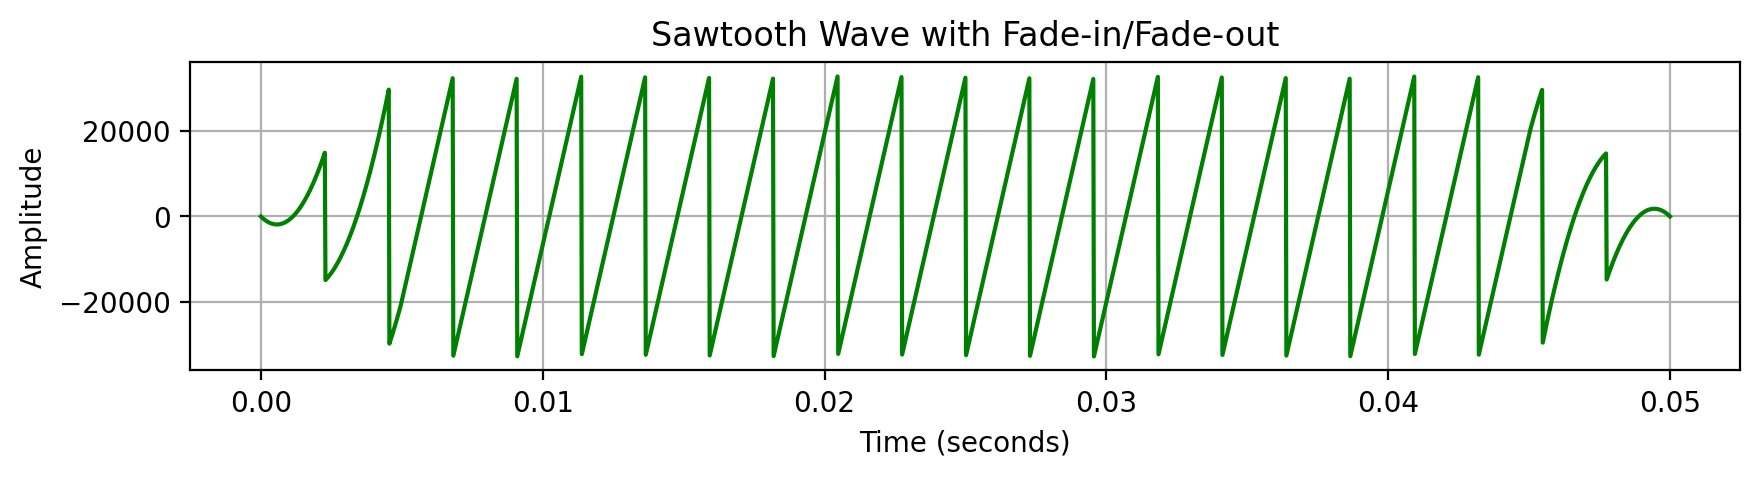

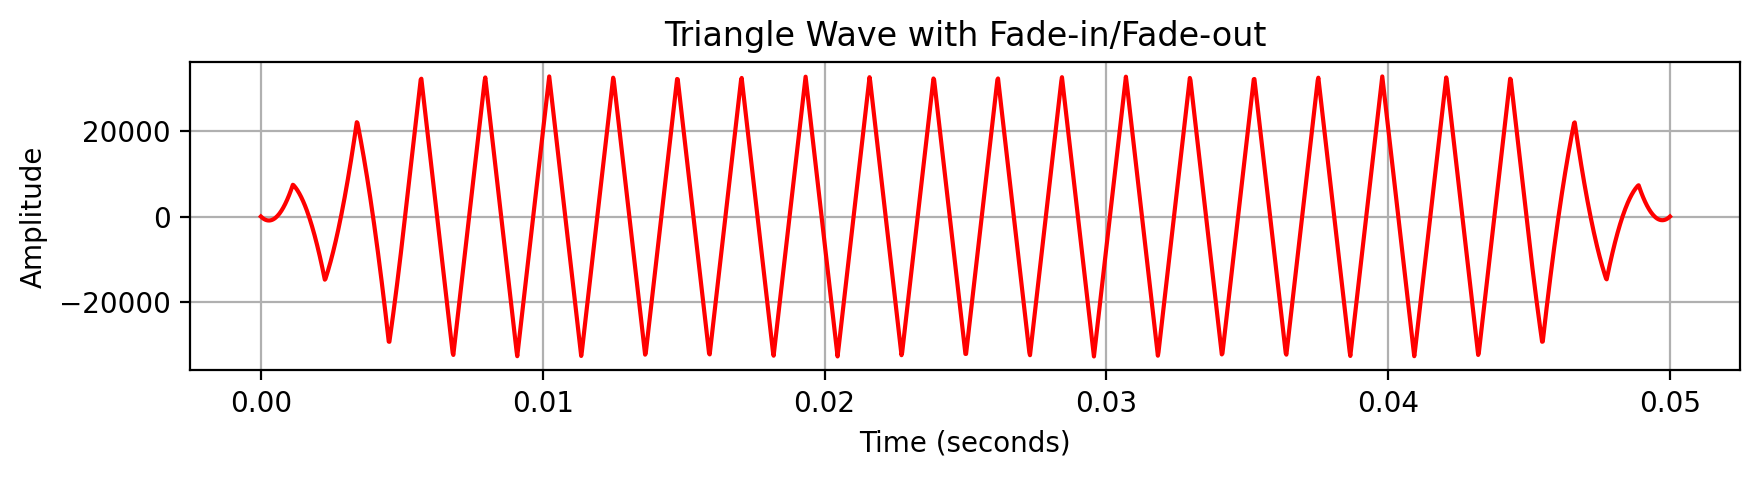

In [187]:
# Visualization of a generated waveform for a given note.
test_frequency = 440  # A4
visual_duration = 0.05  # seconds
sound_duration = 1  # seconds
sample_rate = 44100
attack=0.01
decay=0.1
sustain_level=0.7
release=0.1
# Generate the waveform using the basic sine wave with fade
wave = generate_sine_wave(test_frequency, visual_duration, sample_rate)
time_axis = np.linspace(0, visual_duration, len(wave))

plt.figure(figsize=(10, 2))
plt.plot(time_axis, wave, color='blue')
plt.title("Sine Wave with Fade-in/Fade-out")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_sine_wave(test_frequency, sound_duration, sample_rate), sample_rate)

# wave = apply_adsr_envelope(wave, sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)
# time_axis = np.linspace(0, visual_duration, len(wave))

# plt.figure(figsize=(10, 2))
# plt.plot(time_axis, wave, color='blue')
# plt.title("Sine Wave with ADSR Envelope")
# plt.xlabel("Time (seconds)")
# plt.ylabel("Amplitude")
# plt.grid(True)
# plt.show()

# play_audio(wave, sample_rate)

harmonics = [1, 0.95, 0.85, 0.25]
harmonic_wave = generate_harmonic_wave(test_frequency, visual_duration, harmonics)

plt.figure(figsize=(10, 2))
plt.plot(np.linspace(0, visual_duration, len(harmonic_wave)), harmonic_wave, color='green')
plt.title("Harmonic Wave")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_harmonic_wave(test_frequency, sound_duration, harmonics), sample_rate)

# harmonic_wave_adsr = apply_adsr_envelope(harmonic_wave, sample_rate, attack=attack, decay=decay, sustain_level=sustain_level, release=release)

# plt.figure(figsize=(10, 2))
# plt.plot(np.linspace(0, visual_duration, len(harmonic_wave_adsr)), harmonic_wave_adsr, color='green')
# plt.title("Harmonic Wave with ASDR Envelope")
# plt.xlabel("Time (seconds)")
# plt.ylabel("Amplitude")
# plt.grid(True)
# plt.show()

# play_audio(harmonic_wave_adsr, sample_rate)

# Generate and plot square wave
square_wave = generate_square_wave(test_frequency, visual_duration, sample_rate=sample_rate)
time_axis = np.linspace(0, visual_duration, len(square_wave))
plt.figure(figsize=(10, 2))
plt.plot(time_axis, square_wave, color='blue')
plt.title("Square Wave with Fade-in/Fade-out")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_square_wave(test_frequency, sound_duration, sample_rate), sample_rate)

# Generate and plot sawtooth wave
sawtooth_wave = generate_sawtooth_wave(test_frequency, visual_duration, sample_rate=sample_rate)
plt.figure(figsize=(10, 2))
plt.plot(np.linspace(0, visual_duration, len(sawtooth_wave)), sawtooth_wave, color='green')
plt.title("Sawtooth Wave with Fade-in/Fade-out")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_sawtooth_wave(test_frequency, sound_duration, sample_rate), sample_rate)

# Generate and plot triangle wave
triangle_wave = generate_triangle_wave(test_frequency, visual_duration, sample_rate=sample_rate)
time_axis = np.linspace(0, visual_duration, len(triangle_wave))
plt.figure(figsize=(10, 2))
plt.plot(time_axis, triangle_wave, color='red')
plt.title("Triangle Wave with Fade-in/Fade-out")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

play_audio(generate_triangle_wave(test_frequency, sound_duration, sample_rate), sample_rate)



## How to Run This Notebook Locally

1. **Install Jupyter Notebook (if not already installed):**
   
   Open your terminal or command prompt and run:
   ```bash
   pip install notebook
   ```

2. **Launch Jupyter Notebook:**
   
   Navigate to the directory where this notebook file is saved and run:
   ```bash
   jupyter notebook
   ```
   Your browser will open to the Jupyter dashboard.

3. **Open the Notebook:**
   Click on `FurElise_Synthesis.ipynb` in the dashboard to open it.

4. **Run the Cells:**
   You can run each cell by selecting it and pressing **Shift+Enter**, or use **Kernel > Restart & Run All** to execute all cells in order.

5. **Playback and Visualization:**
   - If you plan to extract a melody from a MusicXML file (e.g., `FurElise.xml`), place it in the same directory and uncomment the relevant lines in the cells.
   - Use the visualization cells to see the waveform shapes.

Enjoy exploring and tweaking the synthesis parameters!